In [1]:
#!pip install torchio

In [2]:
%autosave 60

import os
import sys
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv3D
from keras.layers import Conv3DTranspose
from keras.layers import MaxPool3D
from keras.layers import UpSampling3D
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Flatten
from google.colab import drive
import cv2
#import torchio as tio
#import torch
import gc
import keras.backend as K
from datetime import datetime
from google.colab import files
import zipfile
import random
from skimage.transform import resize

Autosaving every 60 seconds


In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
archive = "2048cropped.zip"
!cp -r drive/MyDrive/arrays/$archive /content/sample_data/$archive
zipfile.ZipFile("/content/sample_data/" + archive, 'r').extractall("/content/sample_data")

In [5]:
images_folder = '/content/sample_data/images/'
masks_folder = '/content/sample_data/masks/'
WIDTH = 224
HEIGHT = 224
NUM_LAYERS = 96
NUM_CLASSES = 8

In [6]:
labels_keys = (0,205,420,500,550,600,820,850)

def get_closest_value(target_value):
  return min(labels_keys, key=lambda x: abs(target_value - x))

labels = {
    0 : 0,
    500 : 1,
    600 : 2,
    420 : 3,
    550 : 4,
    205 : 5,
    820 : 6,
    850 : 7
}

labels_reversed = {
    0 : 0,
    1 : 500,
    2 : 600,
    3 : 420,
    4 : 550,
    5 : 205,
    6 : 820,
    7 : 850
}

TYPE = 'float16'
BATCH_SIZE = 20

def masks_categorization_reverse(masks):
  masks = np.argmax(masks, axis=4)

  for i in range(masks.shape[0]):
      for j in range(masks.shape[1]):
        for k in range(masks.shape[2]):
          for m in range(masks.shape[3]):
            masks[i,j,k,m] = labels_reversed[masks[i,j,k,m]]

  masks = np.expand_dims(masks, 4)

  return masks


In [7]:
def load_data(first, num):
  images = []
  masks = []
  for i in range(first, first + num):
    image = np.load(images_folder + str(i) + ".npy")
    mask = np.load(masks_folder + str(i) + ".npy")
    images.append(image)
    masks.append(mask)
  images = np.array(images)
  masks = np.array(masks)
  return images, masks

def get_values(arr):
  arr_vals = set()

  if type(arr) == list:
    for i in range(len(arr)):
      for j in range(arr[i].shape[0]):
        for k in range(arr[i].shape[1]):
          for m in range(arr[i].shape[2]):
            arr_vals.add(arr[i][j,k,m,0])

  else:
    for i in range(arr.shape[0]):
      for j in range(arr.shape[1]):
        for k in range(arr.shape[2]):
          for m in range(arr.shape[3]):
            arr_vals.add(arr[i,j,k,m,0])

  return arr_vals


def save_model(model_):
  now = datetime.now()
  current_time = now.strftime("%H_%M_%S")
  model_.save('drive/MyDrive/models/ManyLayers_PATCH_3D' + current_time + ".keras")

In [8]:

def down_conv(prev_layer, num_layers,  kernel_size=(3,3,3), padding="same", strides=1, activation="relu"):
  conv = Conv3D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(prev_layer)
  norm = keras.layers.BatchNormalization()(conv)
  conv = Conv3D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation, dilation_rate=1)(norm)
  norm = keras.layers.BatchNormalization()(conv)
  pool = MaxPool3D((1,2,2))(norm)

  return [conv, pool]

def up_conv(prev_layer, skip_layer, num_layers,  kernel_size=(3,3,3), padding="same", strides=1, activation="relu"):
  upsamp = UpSampling3D((1,2,2))(prev_layer)
  conc = Concatenate()([upsamp, skip_layer])
  conv = Conv3D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conc)
  norm = keras.layers.BatchNormalization()(conv)
  conv = Conv3D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation, dilation_rate=1)(norm)
  norm = keras.layers.BatchNormalization()(conv)

  return norm

def bootle_neck(prev_layer, num_layers,  kernel_size=(3,3,3), padding="same", strides=1, activation="relu"):
  conv = Conv3D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation, dilation_rate=1)(prev_layer)
  norm = keras.layers.BatchNormalization()(conv)
  conv = Conv3D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation, dilation_rate=1)(norm)
  norm = keras.layers.BatchNormalization()(conv)

  return norm

def reduce_layers(layer):
  return Conv3D(NUM_CLASSES, (1,1,1), padding="same", activation="softmax")(layer)

In [9]:
def DiceScore(targets, inputs, smooth=1e-6):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return dice

def DiceLoss(targets, inputs, smooth=1e-6):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def loss_sum(targets, inputs):
  return DiceLoss(targets, inputs) + keras.losses.CategoricalFocalCrossentropy(targets, inputs)

In [16]:
BASE_NUM_LAYERS = 22

input = keras.layers.Input((NUM_LAYERS, WIDTH, HEIGHT, 1))

conv1, pool1 = down_conv(input, BASE_NUM_LAYERS)
conv2, pool2 = down_conv(pool1, BASE_NUM_LAYERS * 2)
conv3, pool3 = down_conv(pool2, BASE_NUM_LAYERS * 4)
conv4, pool4 = down_conv(pool3, BASE_NUM_LAYERS * 8)
conv5, pool5 = down_conv(pool4, BASE_NUM_LAYERS * 16)

bneck = bootle_neck(pool5, BASE_NUM_LAYERS * 32)

up1 = up_conv(bneck, conv5, BASE_NUM_LAYERS * 16)
up2 = up_conv(up1, conv4,   BASE_NUM_LAYERS * 8)
up3 = up_conv(up2, conv3,   BASE_NUM_LAYERS * 4)
up4 = up_conv(up3, conv2,   BASE_NUM_LAYERS * 2)
up5 = up_conv(up4, conv1,   BASE_NUM_LAYERS)

output = reduce_layers(up5)

model = keras.models.Model(input, output)

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss="CategoricalFocalCrossentropy", metrics=
  [
   "accuracy",
   keras.metrics.Recall(),
   keras.metrics.Precision(),
  ])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 224, 224, 1)]    0         []                            
                                                                                                  
 conv3d_46 (Conv3D)          (None, 96, 224, 224, 22)     616       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_44 (Ba  (None, 96, 224, 224, 22)     88        ['conv3d_46[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv3d_47 (Conv3D)          (None, 96, 224, 224, 22)     13090     ['batch_normalization_44

In [17]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, num_batches):
       self.num_batches = num_batches
       self.indexes = [i for i in range(self.num_batches)]

    def __len__(self):
        return self.num_batches

    def __getitem__(self, index):
        index_ = random.choice(self.indexes)
        X, y = load_data(index_, 1)
        y = keras.utils.to_categorical(y, num_classes=NUM_CLASSES)
        self.indexes.remove(index_)

        return X, y

    def on_epoch_end(self):
        self.indexes = [i for i in range(self.num_batches)]

In [18]:
#model_name = '/content/drive/MyDrive/models/ManyLayers_PATCH_3D22_35_43.keras'

In [19]:
#model = keras.models.load_model(model_name)

In [ ]:
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss="CategoricalFocalCrossentropy", metrics=
#  [
#   "accuracy",
#   keras.metrics.Recall(),
#   keras.metrics.Precision(),
#  ])
dataGen = DataGenerator(20)
model.fit_generator(generator=dataGen, use_multiprocessing=True, workers=10, epochs=10)
save_model(model)

<ipython-input-20-bcd2dff11048>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=dataGen, use_multiprocessing=True, workers=10, epochs=10)


Epoch 1/10


In [ ]:
model = keras.models.load_model(model_name)

1/1 [==============================] - 61s 61s/step


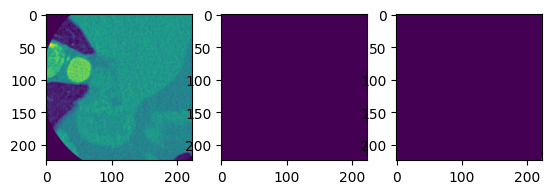

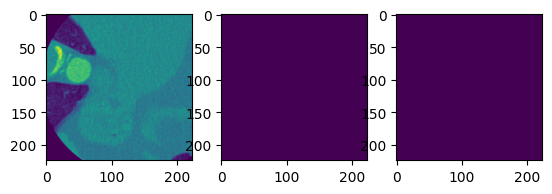

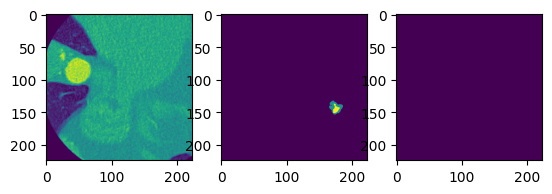

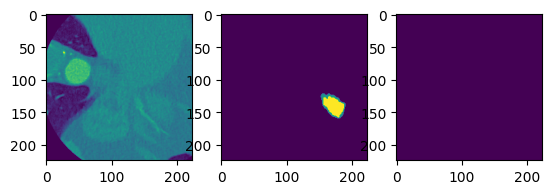

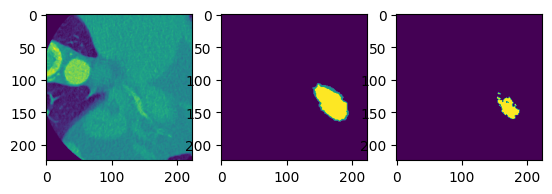

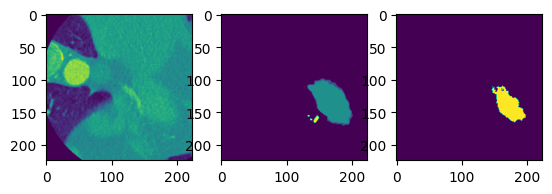

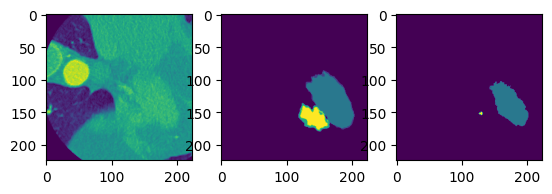

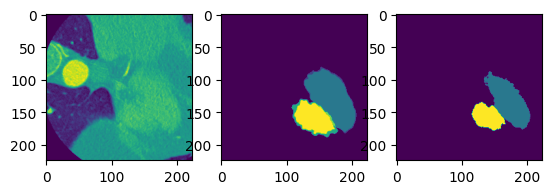

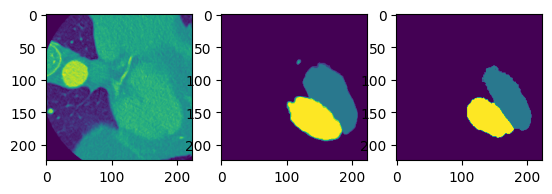

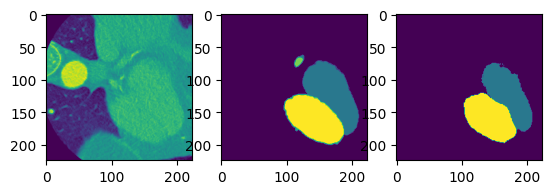

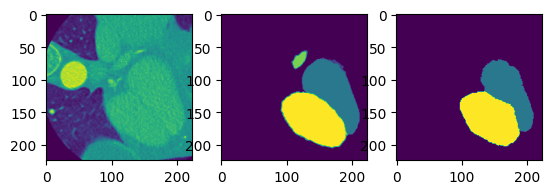

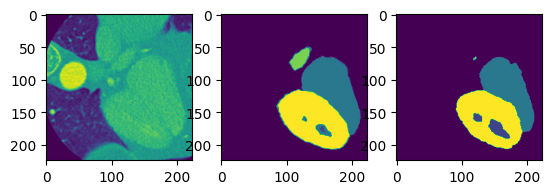

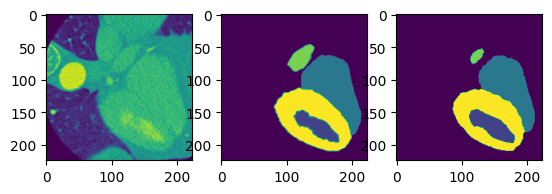

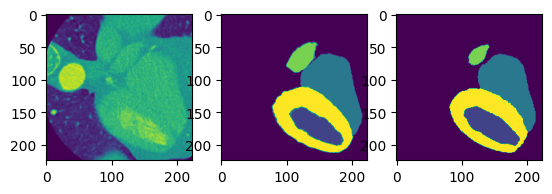

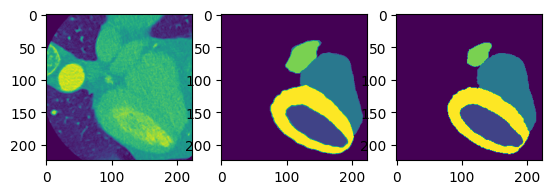

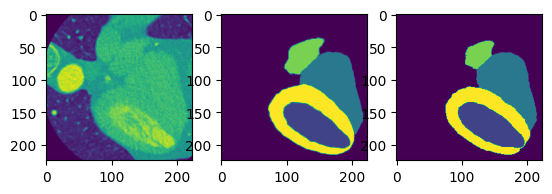

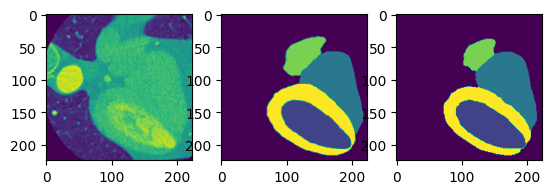

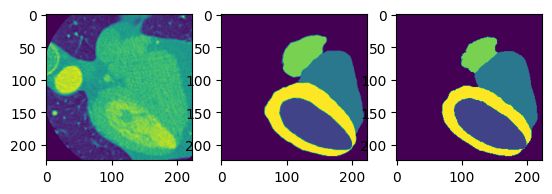

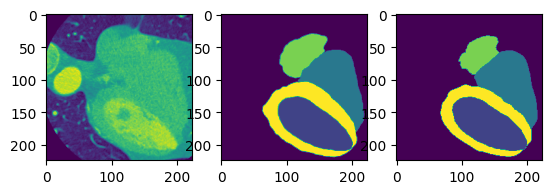

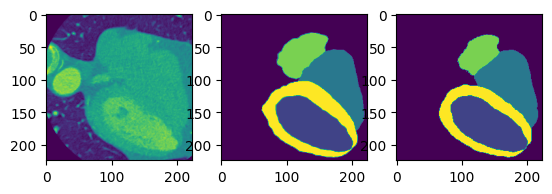

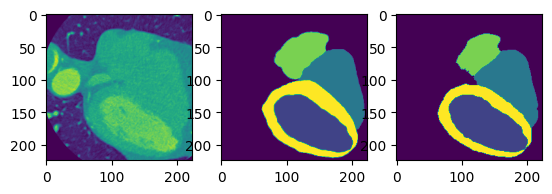

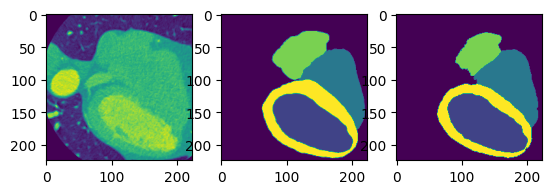

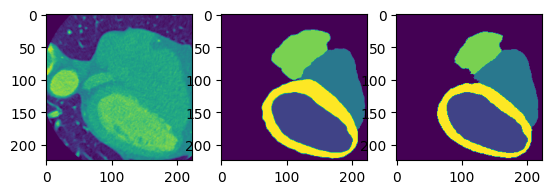

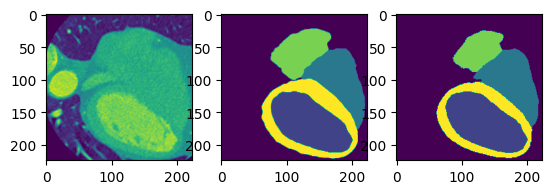

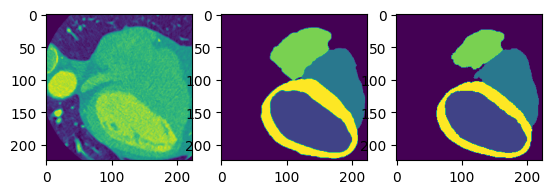

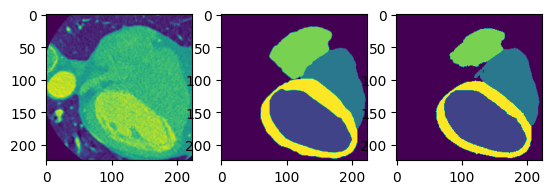

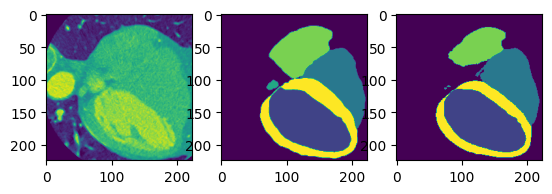

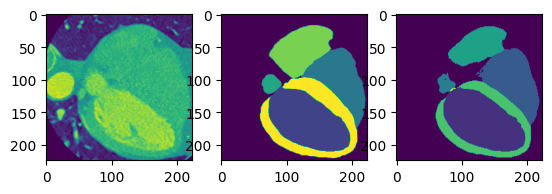

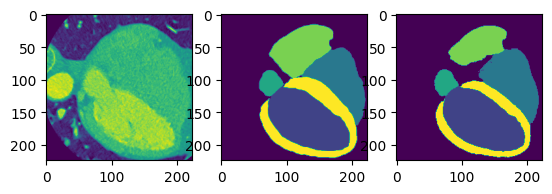

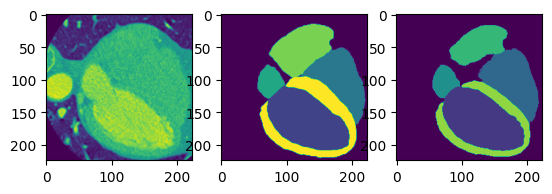

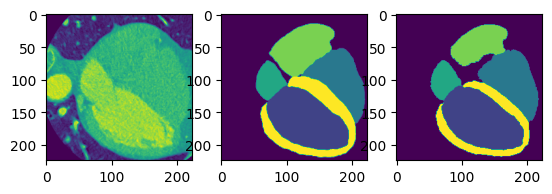

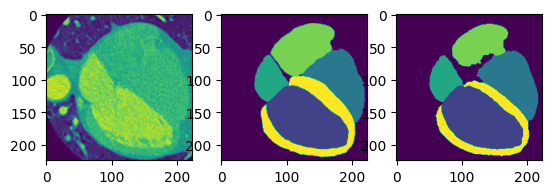

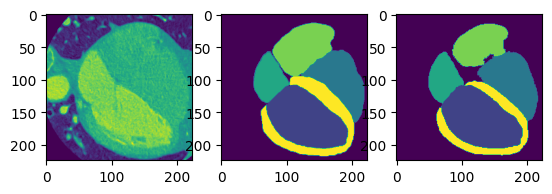

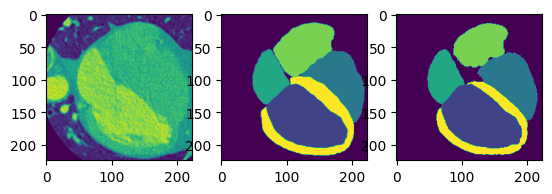

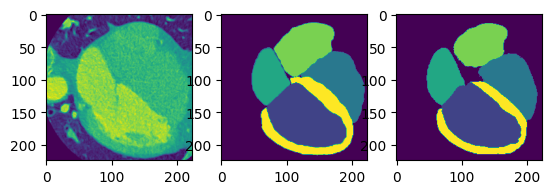

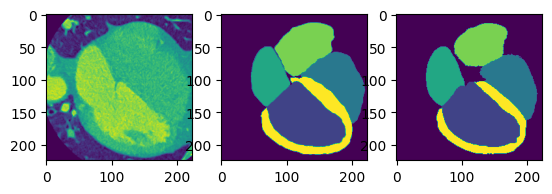

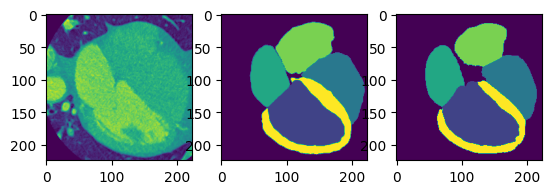

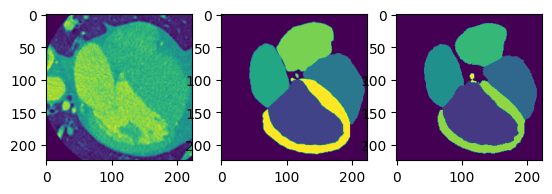

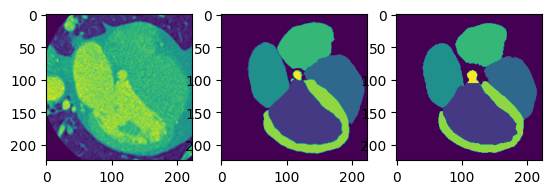

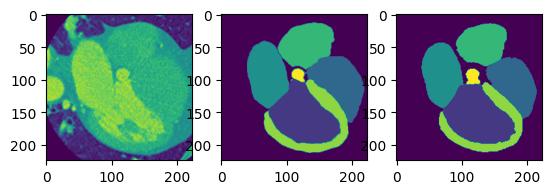

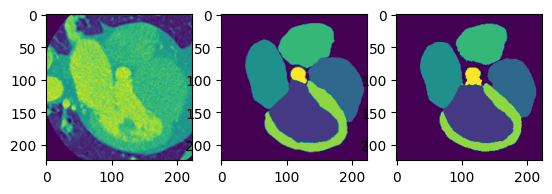

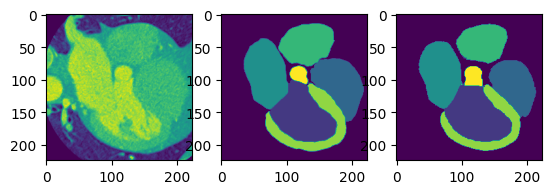

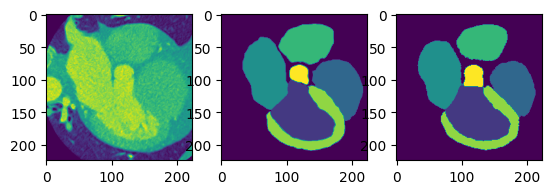

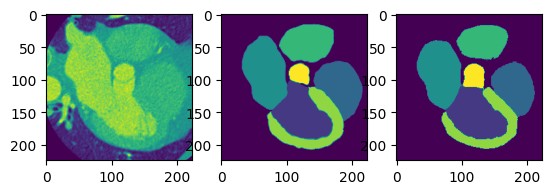

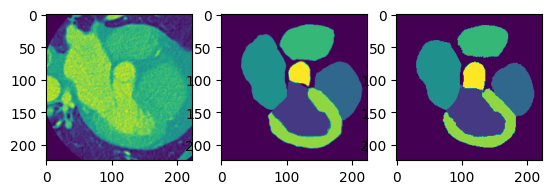

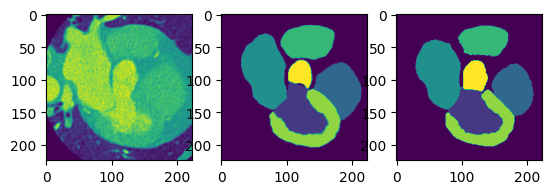

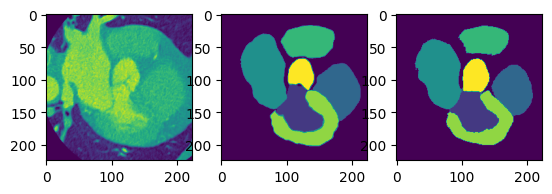

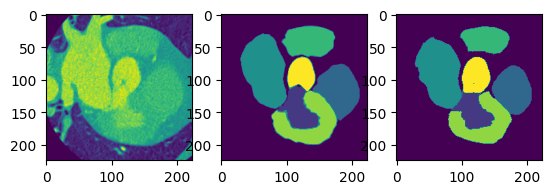

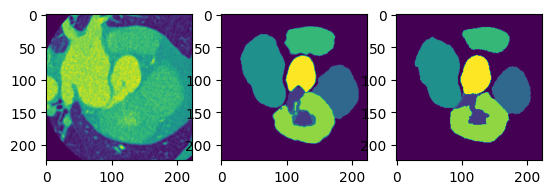

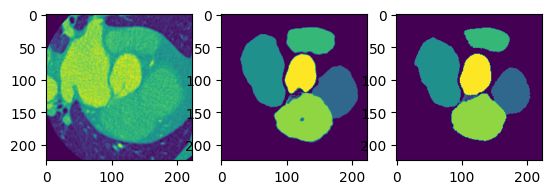

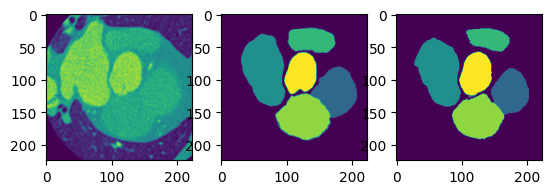

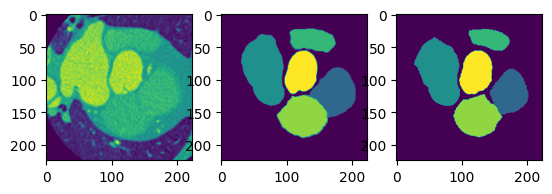

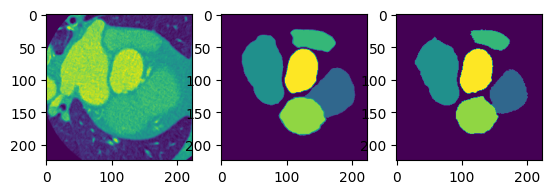

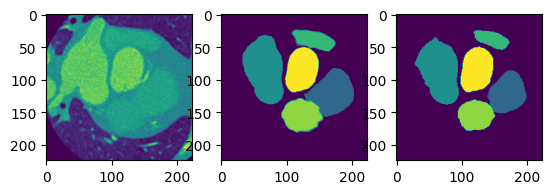

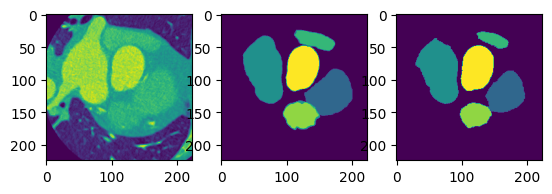

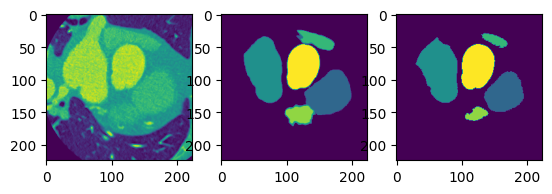

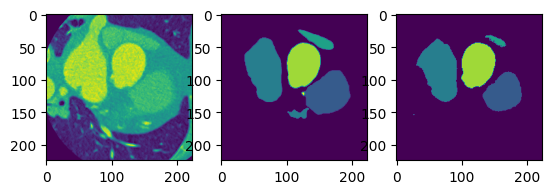

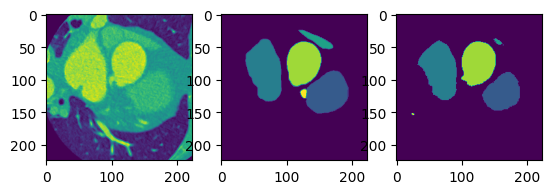

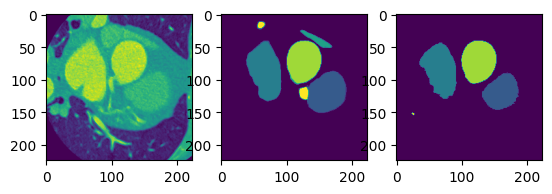

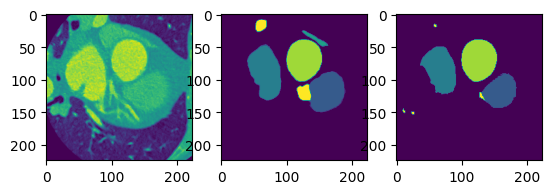

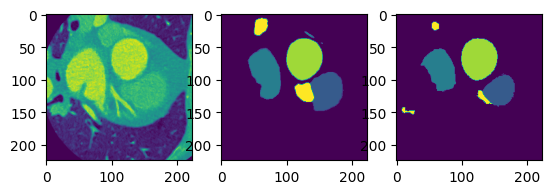

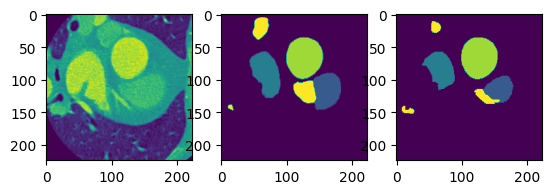

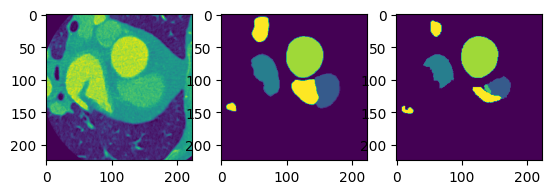

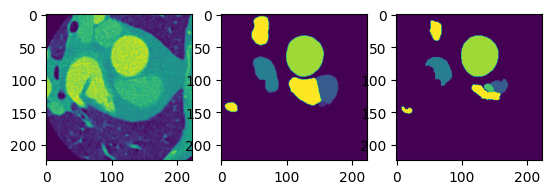

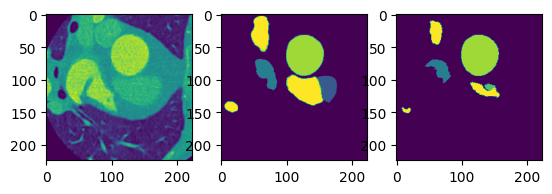

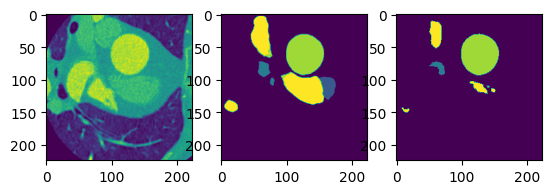

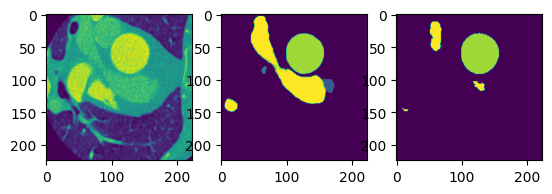

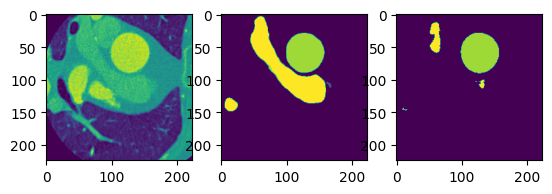

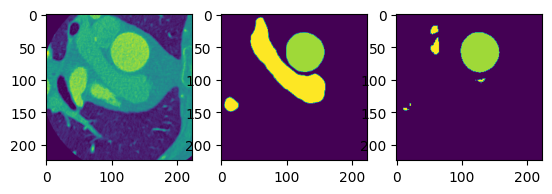

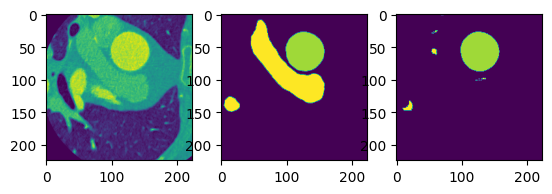

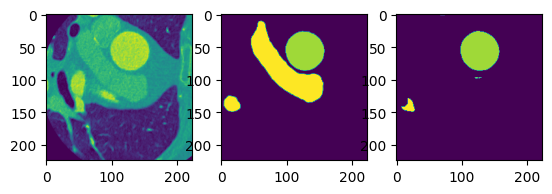

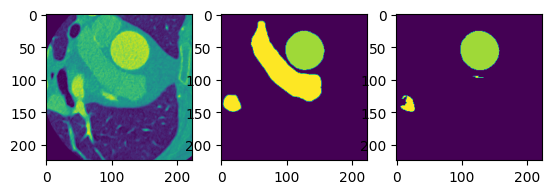

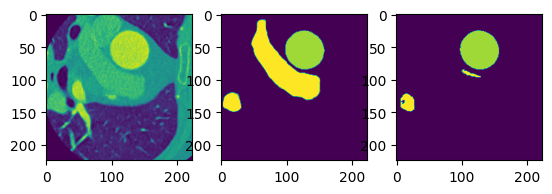

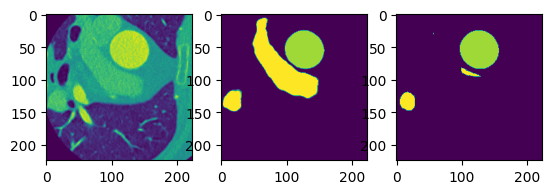

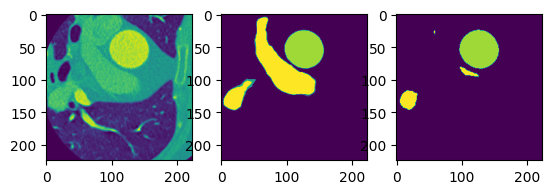

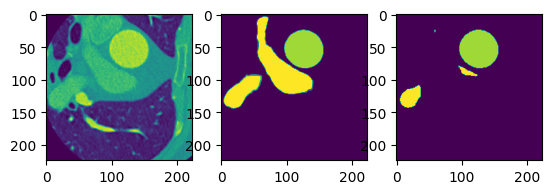

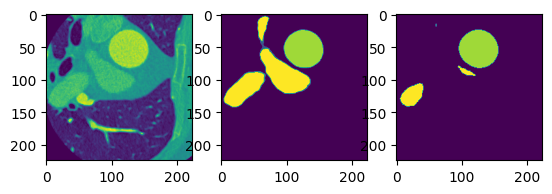

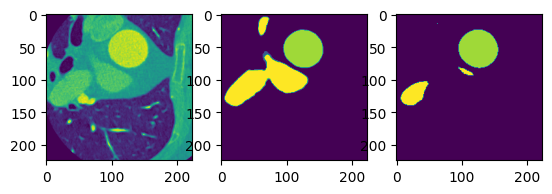

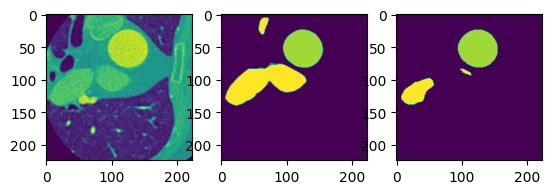

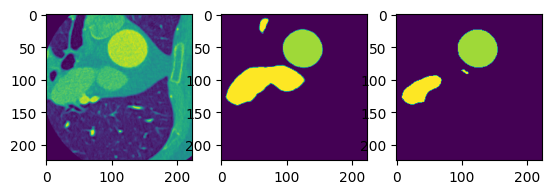

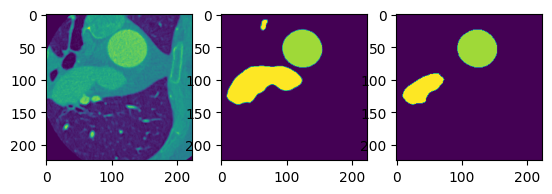

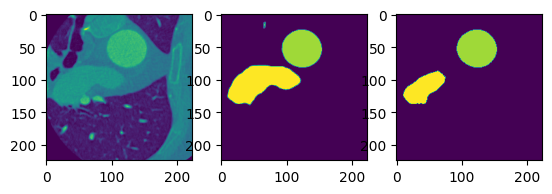

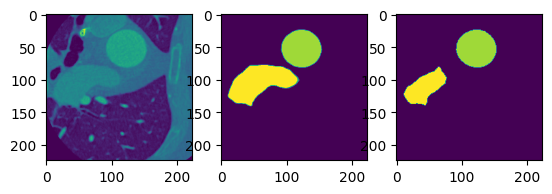

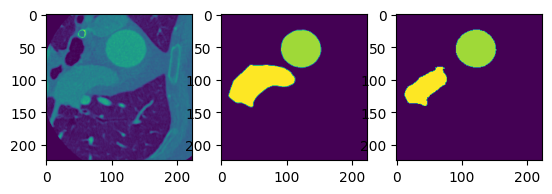

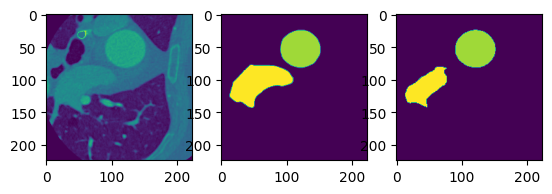

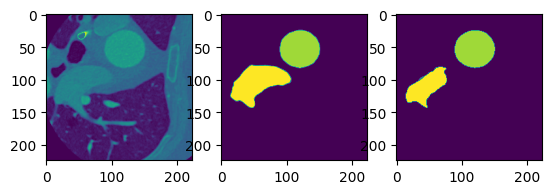

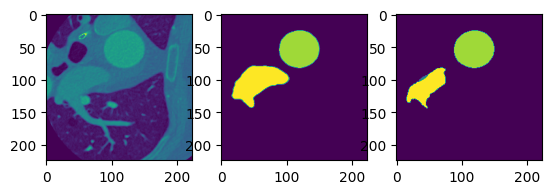

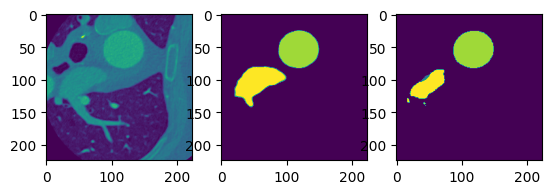

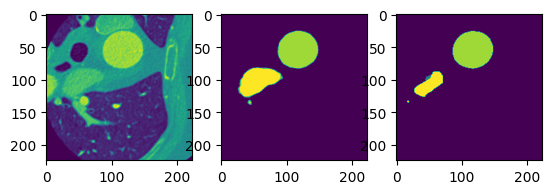

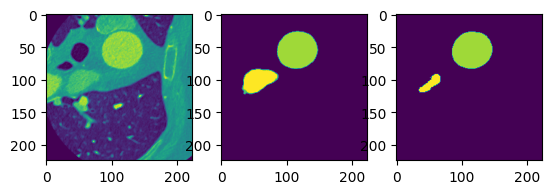

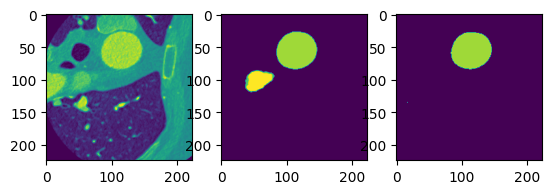

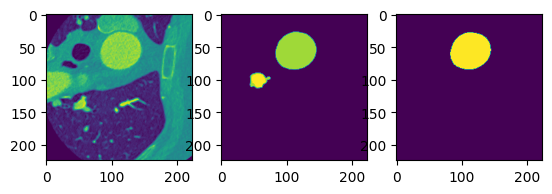

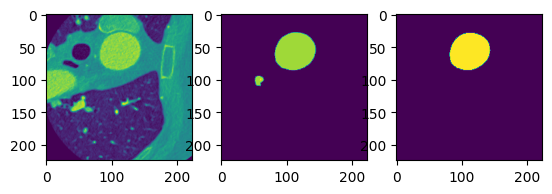

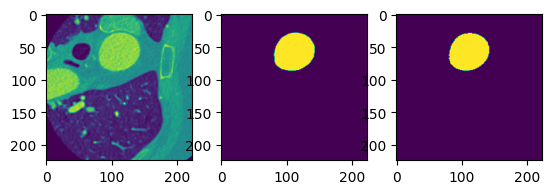

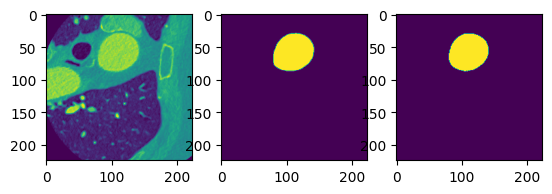

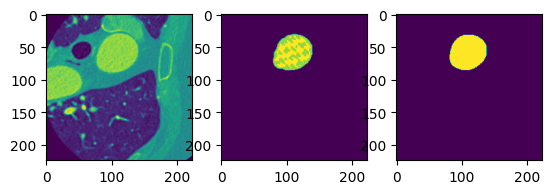

In [ ]:
images, masks = load_data(15,1)
pred = model.predict(images)
pred = np.argmax(pred, axis=4)

for i in range(pred.shape[1]):
  plt.subplot(131)
  plt.imshow(images[0,i])
  plt.subplot(132)
  plt.imshow(masks[0,i])
  plt.subplot(133)
  plt.imshow(pred[0,i])
  plt.show()